In [1]:
import tensorflow as tf
import keras as K

Using TensorFlow backend.


In [2]:
import pandas as pd
import os

In [3]:
#train_dir = "../../training_images"
train_dir = "/Users/cvsox/data/RSNA-pneumonia/stage_1/stage_1_train_images"
train_csv = os.path.join(train_dir, "../" )

In [4]:
#df = pd.read_csv(os.path.join(train_dir, "train_gen.csv"))
df = pd.read_csv(os.path.join(train_csv, "train_gen.csv"))

In [5]:
df.iloc[100]

patientId      03cd7a5b-d5d7-40a1-81b1-c4264920530a
x1                                              667
y1                                              125
width1                                          255
height1                                         749
confidence1                                       1
x2                                              284
y2                                              170
width2                                          215
height2                                         571
confidence2                                       1
x3                                                0
y3                                                0
width3                                            0
height3                                           0
confidence3                                       0
x4                                                0
y4                                                0
width4                                            0
height4     

In [6]:
import SimpleITK as sitk
import numpy as np
from skimage.transform import resize

class DataGenerator(K.utils.Sequence):
    """
    Generates data for Keras/TensorFlow
    Code based on https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    This uses the Keras Sequence which is better for multiprocessing.
    The main input the dataloader is a list of filenames containing
    the images to load. 
    If you have a different type of dataset, you'll just need to
    change the loading code in self.__data_generation to return
    the correct image and label.
    """
    
    def __init__(self,
                 df,     # List of file names for raw images/masks
                 path= "../../training_images", # Path for images
                 batch_size=64,  # batch size
                 dim=(128,128),  # Dimension of images
                 n_in_channels=1,  # Number of channels in image
                 shuffle=True,  # Shuffle list after each epoch
                 augment=False,   # Augment images
                 seed=816):     # Seed for random number generator
        """
        Initialization
        """
        self.dim = dim
        self.path = path
        self.batch_size = batch_size
        self.df = df
        self.n_in_channels = n_in_channels
        self.shuffle = shuffle
        self.augment = augment
        self.originalsize = self.get_size()
        self.scale = self.get_scale()
        
        np.random.seed(seed)
        self.on_epoch_end()   # Generate the sequence

    def __len__(self):
        """
        The number of batches per epoch
        """
        return len(self.df) // self.batch_size

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        # Generate indicies of the batch
        indexes = np.sort(
            self.indexes[index*self.batch_size:(index+1)*self.batch_size])

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y
    
    def normalize(self, image):
        
        """
        normalize each image by subtracting its mean and divide by the standard deviation
      
        """
        image = (image - np.mean(image))/(np.std(image))
        
        return image
    
    def resize_image(self, image):
        
        """
        resize the image into new height and new width
        
        """
        
        image = resize(image, self.dim, anti_aliasing=True, mode="constant")
        return image
    
    def get_size(self):
        """
        get the image size
        
        """
        
        info = self.df.iloc[0]
        itkimage = sitk.ReadImage(os.path.join(self.path, info["patientId"] + ".dcm"))
            
        img = np.moveaxis(sitk.GetArrayFromImage(itkimage), 0, -1)
        
        return img.shape[0], img.shape[1]
    
    def get_scale(self):
        """
        calculate the scale of the output image to the input image
        """
        info = self.df.iloc[0]
        itkimage = sitk.ReadImage(os.path.join(self.path, info["patientId"] + ".dcm"))
            
        img = np.moveaxis(sitk.GetArrayFromImage(itkimage), 0, -1)
        
        return self.dim[0]/img.shape[0], self.dim[1]/img.shape[1]

    def on_epoch_end(self):
        """
        Updates indices after each epoch
        If shuffle is true, then it will shuffle the training set
        after every epoch.
        """
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def scale_bbox(self, bbox):
        
        """
        scaling bbox
        """
        bbox = np.array(bbox)
        bbox[0::5] = bbox[0::5]/self.originalsize[0]
        bbox[1::5] = bbox[1::5]/self.originalsize[1]
        bbox[2::5] = bbox[2::5]/self.originalsize[0]
        bbox[3::5] = bbox[3::5]/self.originalsize[1]
        
        return bbox
    
    def data_sample(self):
        """
        raise todo
        """
#         imgs = np.zeros((self.batch_size, *self.dim, self.n_in_channels))
        patient_image = self.df[self.df["confidence1"]==1].sample(1)
        img_reader = sitk.ReadImage(os.path.join(train_dir, patient_image['patientId'].values[0] + ".dcm"))
        img = np.moveaxis(sitk.GetArrayFromImage(img_reader), 0, -1)
        scalex = img.shape[0]
        scaley = img.shape[1]
        img = self.normalize(self.resize_image(img))
#       imgs[idx,] = img
        bbox = patient_image.iloc[:, 1:6].values.tolist()[0]
        bbox[0] = bbox[0]/scalex
        bbox[1] = bbox[1]/scaley
        bbox[2] = bbox[2]/scalex
        bbox[3] = bbox[3]/scaley

        return np.expand_dims(img, 0), bbox

    def data_sample_noresize(self):
        """
        raise todo
        """
#         imgs = np.zeros((self.batch_size, *self.dim, self.n_in_channels))
        patient_image = self.df[self.df["confidence1"]==1].sample(1)
        img_reader = sitk.ReadImage(os.path.join(train_dir, patient_image['patientId'].values[0] + ".dcm"))
        img = np.moveaxis(sitk.GetArrayFromImage(img_reader), 0, -1)
        scalex = 1
        scaley = 1
        #img = self.normalize(self.resize_image(img))
#       imgs[idx,] = img
        bbox = patient_image.iloc[:, 1:5].values.tolist()[0]
        bbox[0] = bbox[0]/scalex
        bbox[1] = bbox[1]/scaley
        bbox[2] = bbox[2]/scalex
        bbox[3] = bbox[3]/scaley

        return np.expand_dims(img, 0), bbox
   
    def __data_generation(self, list_IDs_temp):
        """
        Generates data containing batch_size samples
        This just reads the list of filename to load.
        Change this to suit your dataset.
        """

        # Make empty arrays for the images and bbox batches
        imgs = np.zeros((self.batch_size, *self.dim, self.n_in_channels))
        
        bboxes = np.zeros((self.batch_size, 4))  # four boxes of [X,Y,H,W,Confidence]

        for idx, file in enumerate(list_IDs_temp):
            
            info = self.df.iloc[file]
            itkimage = sitk.ReadImage(os.path.join(self.path, info["patientId"] + ".dcm"))
            
            img = np.moveaxis(sitk.GetArrayFromImage(itkimage), 0, -1)
            img = self.normalize(self.resize_image(img))
            imgs[idx,] = img
            
            # bboxes
            bboxes[idx,] = self.scale_bbox(list(info)[1:5])
            
        return imgs, bboxes

In [18]:
training_data_params = {"dim": (128,128),
                        "batch_size": 32,
                        "n_in_channels": 1,
                        "shuffle": True,
                        "seed": 810,
                        "path": train_dir}

training_generator = DataGenerator(df=df[df["confidence1"]==1], **training_data_params)

In [19]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

In [86]:
# custom metrics function
def bbox_iou_corner_xy(bboxes1, bboxes2):
    """
    Args:
        bboxes1: shape (total_bboxes1, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (total_bboxes2, 4)
            with x1, y1, x2, y2 point order.

        p1 *-----
           |     |
           |_____* p2

    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """

    x11, y11, x12, y12 = tf.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = tf.split(bboxes2, 4, axis=1)

    xI1 = tf.maximum(x11, tf.transpose(x21))
    xI2 = tf.minimum(x12, tf.transpose(x22))

    yI1 = tf.minimum(y11, tf.transpose(y21))
    yI2 = tf.maximum(y12, tf.transpose(y22))

    inter_area = tf.maximum((xI2 - xI1), 0) * tf.maximum((yI1 - yI2), 0)

    bboxes1_area = tf.abs(x12 - x11) * tf.abs(y11 - y12)
    bboxes2_area = tf.abs(x22 - x21) * tf.abs(y21 - y22)

    union = (bboxes1_area + tf.transpose(bboxes2_area)) - inter_area

    # some invalid boxes should have iou of 0 instead of NaN
    # If inter_area is 0, then this result will be 0; if inter_area is
    # not 0, then union is not too, therefore adding a epsilon is OK.
    return inter_area / (union+0.0001)

In [87]:
def custom_loss(bboxes1, bboxes2):
    return -K.backend.log(bbox_iou_corner_xy(bboxes1, bboxes2) + 0.00001) + K.losses.mean_squared_error(bboxes1, bboxes2)

In [88]:
# SAMPLE IMG CODE
sample_img = training_generator.data_sample_noresize()
#print(sample_img.shape)

def sample_plot(sample_img, truth_box, scale_factor):
    fig,ax = plt.subplots()

    idx = 0
    print(np.shape(sample_img[1]) , 0)

    ax.imshow(sample_img[0][idx,:,:,0],cmap=plt.cm.gist_gray)
    x1 = sample_img[1][0] * scale_factor
    y1 = sample_img[1][1] * scale_factor
    h1 = sample_img[1][2] * scale_factor
    w1 = sample_img[1][3] * scale_factor
    rect1 = Rectangle((x1,y1),w1,h1,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect1)
    x = truth_box[0] * scale_factor
    y = truth_box[1] * scale_factor
    h = truth_box[2] * scale_factor
    w = truth_box[3] * scale_factor
    rect2 = Rectangle((x,y),w,h,linewidth=1,edgecolor='y',facecolor='none')
    ax.add_patch(rect2)
    ax.text(x+w//2,y+h//2, str(round(sample_img[1][4],0)), fontsize=15)\

#print(x+w)

In [89]:
#a = training_generator.__getitem__(1)
#a.shape

KeyError: 0

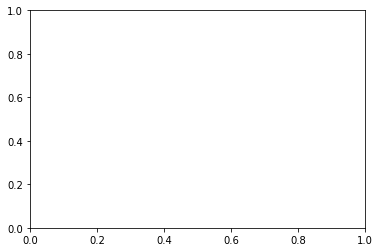

In [53]:
fig,ax = plt.subplots()

idx = 1
ax.imshow(a[0][idx,:,:,0])
x = a[1][idx,:][0] * training_data_params["dim"][0]
y = a[1][idx,:][1] * training_data_params["dim"][1]
h = a[1][idx,:][2] * training_data_params["dim"][0]
w = a[1][idx,:][3] * training_data_params["dim"][1]
rect = Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.text(x+w//2,y+h//2, str(round(a[1][idx,:][4],0)), fontsize=15)



In [90]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard

def first_model(width, height, channel):
    num_classes = 4

    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
          activation='relu',
          input_shape=(height, width, channel)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation=None))
    
    model.compile(loss=custom_loss,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['mse', bbox_iou_corner_xy])
    model.summary()
    return model
    

In [91]:
model = first_model(training_data_params['dim'][0], training_data_params['dim'][1], \
                    training_data_params['n_in_channels'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 246016)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               31490176  
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
__________

In [92]:
tensorboard = TensorBoard(log_dir="logs/singlebox", update_freq='batch')

model.fit_generator(training_generator, epochs=3, verbose=1, callbacks=[tensorboard])

Epoch 1/3
 56/176 [========>.....................] - ETA: 4:56 - loss: 39.1467 - mean_squared_error: 27.6587 - bbox_iou_corner_xy: 8.9742e-05

KeyboardInterrupt: 

In [75]:
validation_data_params = {"dim": (128,128),
                        "batch_size": 32,
                        "n_in_channels": 1,
                        "shuffle": True,
                        "seed": 810,
                        "path": train_dir}

validation_generator = DataGenerator(df=df[df["confidence1"]==1], **validation_data_params)
image_sample = validation_generator.data_sample()
prediction = model.predict(image_sample[0])
print(prediction, image_sample[1])

sample_plot(image_sample, prediction[0], 128)

# first_image = a[0][[0]]
# print(first_image.shape)
# print(a[1][0])
# prediction = model.predict(first_image)
# print(prediction)

[[nan nan nan nan]] [0.6181640625, 0.24609375, 0.21484375, 0.3828125, 1.0]
(5,) 0


ValueError: posx and posy should be finite values

In [ ]:
#def get_validation(df, ):
patient_image = df[df["confidence1"]==1].sample(1)
img = sitk.ReadImage(os.path.join(train_dir, patient_image['patientId'].values[0] + ".dcm"))
img 
    

In [ ]:
itkimage = sitk.ReadImage(os.path.join(self.path, info["patientId"] + ".dcm"))
            
            img = np.moveaxis(sitk.GetArrayFromImage(itkimage), 0, -1)
            img = self.normalize(self.resize_image(img))
            imgs[idx,] = img

In [ ]:
patient_image.iloc[:, 1:5].values.tolist()[0]